# Market Data

The trade data for this project is acquired from [Poloniex](https://poloniex.com) exchange, which is the number 1 crypto currency exchange by [daily volume](http://coinmarketcap.com/exchanges/volume/24-hour/). 

From Poloniex we are able to acquire [historical trade data](#Historical-Trade-Data), real-time orderbook data and real-time trollbox data. We start by acquiring the historical trade data and standardizing our samples across markets. We also acquire the real-time data and save it for incorporation in the training model. 

In [1]:
import json
import time
import requests
%matplotlib inline
import pylab
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from IPython.core.display import HTML
HTML('<style>{}</style>'.format( open('style.css').read() ) )

** Create function for requesting Poloniex data **

In [2]:
def poloniex_api(command, args={}):
    url = 'https://poloniex.com/public?command='+command
    for arg, value in args.items():
        url += '&{}={}'.format(arg,value)
    return json.loads(requests.get(url).content.decode('utf-8'))

## Historical Trade Data
The trade data wrangling process requires that we group and standardize the time series data according to time interval. We then group our sample populations by trade type(i.e. buy or sell) and volume level (e.g. high). 



#### Top markets by daily trade volume
First, lets get the markets with the highest daily volume. To keep things simple we only look at BTC denominated markets.

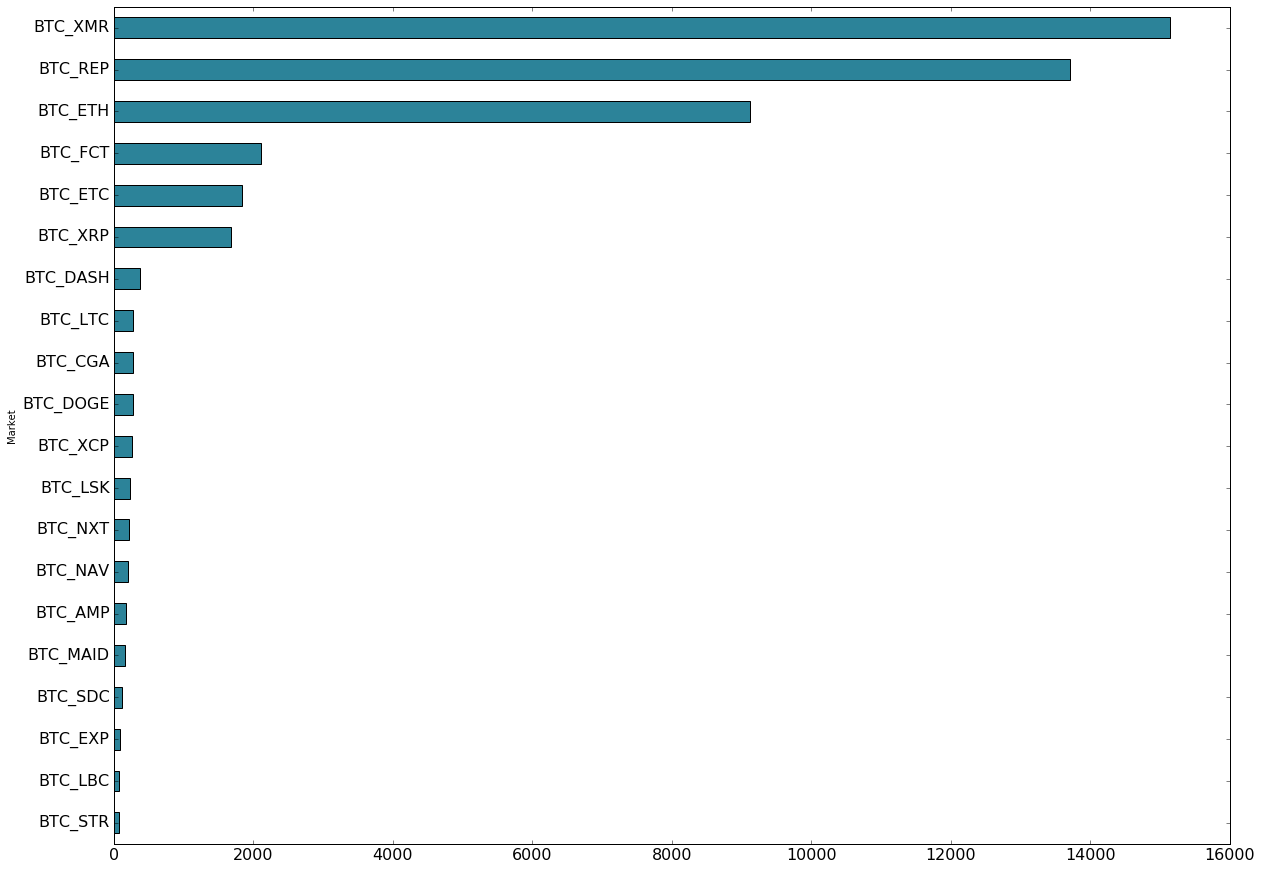

In [3]:
market_volumes = poloniex_api('return24hVolume')
btc_market_volumes = [(m, float(market_volumes[m]['BTC'])) for m in market_volumes if m[:3] == 'BTC']
top_markets = (pd.DataFrame(btc_market_volumes, columns=['Market','Volume'])
     .set_index('Market').sort_values(by='Volume', ascending=False).head(20))

top_markets.Volume.sort_values(0).plot(kind='barh', figsize=(20,15), fontsize=16, color='#2C8399')

#### Acquiring trade data

The function *get_trade* pulls trade data for a given market and from a specified period of time. If the query result is to big to keep in memory the data is requested in chuncks and saved to an output file. 

In [5]:
def get_trades(currency_pair, start, end, save_file=False, file_path='data/'):
    def unix_time(dt):
        return int(time.mktime(dt.timetuple()))
    
    date_fmt = '%Y-%m-%dT%H:%M:%S'
    file_name = file_path+'Trades|{}|{}|{}.csv'.format(
        currency_pair, start.strftime(date_fmt), end.strftime(date_fmt))
    
    trades = pd.DataFrame()
    total_trades = len(trades)
    need_to_fetch = lambda t: len(t) == 0 or len(t) % 50000 == 0
    while need_to_fetch(trades):
        print('fetching trades...')
        new_trades = pd.DataFrame(
            poloniex_api('returnTradeHistory', {
                'currencyPair': currency_pair,
                'start': unix_time(start),
                'end': unix_time(end if len(trades) == 0 
                                 else datetime.utcfromtimestamp(
                            trades.date.tail(1).values[0].tolist()/1e9))
            }))
        
        if new_trades.empty:
            break
        
        for col in ['amount','rate','total']:
            new_trades[col] = new_trades[col].astype(float)
        new_trades['date'] = pd.to_datetime(new_trades.date)
        
        if save_file:
            with open(file_name, 'a') as f:
                new_trades.to_csv(f, index=False)
                trades = new_trades
        else:
            trades = pd.concat([trades, new_trades])
        
        total_trades += len(new_trades)
        print('acquired {} total trades'.format(total_trades))
        
        time.sleep(2)
    
    if save_file:
        return file_name

    return trades 

### XMR trade data

XMR, which is the currency symbol for [Monero](https://getmonero.org/) has the highest trading volume of any of the BTC markets. Monero is a crypto currency that seeks to improve upon the privacy features of Bitcoin. It has recently become popular as the preferred currency for dark web transaction, which has lead to a subsequent rise in its market capitalization and trading volume.

We first acquire, normalize and analize Monero trade data during it's rise in popularity and the period of volativity following that increase price. 

From the end of August to the begininning of September the market capitalization of XMR increased from \$30 to $175 million. We therefore want to look at the trades in month preceeding that spike through September. 

In [6]:
xmr_data = get_trades('BTC_XMR', datetime(2016,8,1), datetime(2016,10,1), save_file=True)


fetching trades...
acquired 50000 total trades
fetching trades...
acquired 100000 total trades
fetching trades...
acquired 150000 total trades
fetching trades...
acquired 200000 total trades
fetching trades...
acquired 250000 total trades
fetching trades...
acquired 300000 total trades
fetching trades...
acquired 350000 total trades
fetching trades...
acquired 400000 total trades
fetching trades...
acquired 450000 total trades
fetching trades...
acquired 500000 total trades
fetching trades...
acquired 550000 total trades
fetching trades...
acquired 600000 total trades
fetching trades...
acquired 650000 total trades
fetching trades...
acquired 700000 total trades
fetching trades...
acquired 750000 total trades
fetching trades...
acquired 800000 total trades
fetching trades...
acquired 850000 total trades
fetching trades...
acquired 900000 total trades
fetching trades...
acquired 950000 total trades
fetching trades...
acquired 1000000 total trades
fetching trades...
acquired 1050000 tota